In [60]:
%matplotlib inline

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))


['sample_submission.csv', 'sample_submission.csv.zip', 'test.csv', 'test.csv.zip', 'train.csv', 'train.csv.zip']


In [62]:
import mlxtend
import pandas_profiling

import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import matplotlib.pyplot as plt


In [63]:
%%time
train_df = pd.read_csv("../input/train.csv")


Wall time: 4.07 s


In [64]:
%%time
test_df = pd.read_csv("../input/test.csv")


Wall time: 58.4 s


In [65]:
%%time
train_df.head()

Wall time: 1e+03 µs


,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [66]:
%%time
test_df.head()

Wall time: 500 µs


,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# defining useful functions

In [67]:

%matplotlib inline

import os

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew #for some statistics

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve

import mlxtend
from mlxtend.plotting import plot_learning_curves

import pandas_profiling





def checkNaValues(dataframe):
    """check nan values in dataframe"""
    
    print("\n# Is there any nan values?: ", dataframe.isna().all().all())
    
    print("## detail missing data ratio")
    #if dataframe.isna().all().all()
    dataframe_na = (dataframe.isna().sum()/len(dataframe))*100
    print(dataframe_na)
    dataframe_na = dataframe_na.drop(
        dataframe_na[dataframe_na == 0].index
    ).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio':dataframe_na})
    print(missing_data)
    
    
    """there is error. so not implemented yet
    # just plot the rate
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x=dataframe_na.index, y=dataframe_na.values)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    """

    
def checkObjTypeColumns(dataframe):
    """Check object dtype columns"""

    print("\n# object dtype columns")
    # object dtypeの列名からその列のデータのみを抽出
    df_object_type = dataframe[dataframe.select_dtypes(['object']).columns]
    #df_object_type = dataframe[[x for x in dataframe.columns if dataframe[x].dtypes == "object"]]
    print(df_object_type.head())
    #print(df_object_type.info()) # not useful info
    print(df_object_type.describe())

    
def checkValueCounts(dataframe):
    """check value counts of each features and find boolean feature or not."""

    print("# value_counts of each feature: ")
    for column in dataframe.columns:
        #print("## ", column, ": ")
        #print(dataframe[column].value_counts().head())
        value_counts = dataframe[column].value_counts().shape[0]
        if value_counts == 1:
            print(column, " -> single value. value count:  ", dataframe[column].value_counts().shape[0])            
        elif value_counts == 2:
            print(column, " -> maybe boolean. value count:  ", dataframe[column].value_counts().shape[0])
        else:
            print(column, " -> not boolean. value count:  ", dataframe[column].value_counts().shape[0])
            

def findSingleValueColmuns(dataframe):
    """check value counts of each features and find single value feature.
    Such column is no meaning to learn.
    """

    single_val_columns = []
    for column in dataframe.columns:
        value_counts = dataframe[column].value_counts().shape[0]
        if value_counts == 1:
            single_val_columns.append(column)
    return single_val_columns

            
def checkCorrelationOfFeatures(dataframe):
    """check correlation matix of each features"""

    # plot corr
    print("\n# correlation matrix")
    corrmat = dataframe.corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat, vmax=0.9, square=True)
    plt.show()
    print(corrmat)
    print()
    
    corr_values = corrmat.iloc[0]
    print("## highest correlation: ", corr_values.sort_values().head())
    print("## lowest correlation: ", corr_values.sort_values().tail())

    
def checkSkewness(dataframe):
    """check skewness of each features"""
    
    #numeric_feats = dataframe.dtypes[all_data.dtypes != "object"].index
    numeric_feats = dataframe.select_dtypes(exclude=['object'])
    #print(numeric_feats)
    # Check the skew of all numerical features
    skewed_feats = numeric_feats.apply(
        lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\n# Skew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    print(skewness)
    
    return skewness
    
    
def checkAllDataInfo(dataframe):
    """print all dataframe info"""

    print(dataframe.head())
    print("\n# shape: ", dataframe.shape)
    print("\n# columns names: ", train_df.columns.values)
    
    print("\n# df.info(): ")
    print(dataframe.info())
    #print("\n# counts dtypes: \n", dataframe.dtypes.value_counts())# it is included in dataframe.info()

    print("\n# df.describe(): ")
    print(dataframe.describe())
    print()
    
    #print()
    #pandas_profiling.ProfileReport(dataframe)
    print()
    checkNaValues(dataframe)
    print()
    checkObjTypeColumns(dataframe)
    print()
    checkValueCounts(dataframe)
    print()
    #checkCorrelationOfFeatures(dataframe)
    
    print()
    checkSkewness(dataframe)
    
    
    
def my_plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        scoring="r2",
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



def checkTargetInfo(dataframe, target_name="y"):
    """print target y value info"""
 
    # plot distribution
    sns.distplot(train_df[target_name], fit=norm)
    (mu, sigma) = norm.fit(train_df[target_name])
    print("mu, sigma:", mu, sigma)

    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('target value distribution')

    
    # plot skewness

    #print("skewness of y", skew(dataframe[target_name]))
    print("skewness of y", train_df[target_name].skew())
    fig = plt.figure()
    res = stats.probplot(train_df[target_name], plot=plt)
    plt.show()

    
    
def checkCorrelationOfSelectedFeatures(dataframe, columns):
    """check correlation matix of each features"""

    # plot corr
    print("\n# correlation matrix")
    corrmat = dataframe[columns].corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)
    plt.show()
    print(corrmat)
    

    
def splitToIdTargetFeatures(dataframe, id_name, target_name):
    """split train df to data, id and taret dataframes
    """
    id_df = dataframe[id_name]
    target_df = dataframe[target_name]
    features_df = dataframe.drop([id_name, target_name], axis=1)
    
    return id_df, target_df, features_df




# EDA

## general info

## checking in details

## checkTargetInfo

mu, sigma: 5944923.32204 8233388.11374
skewness of y 2.08596653759


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


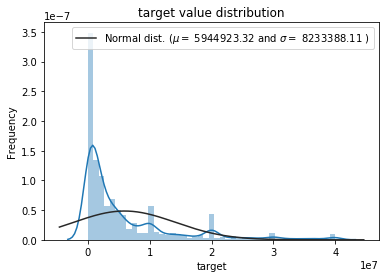

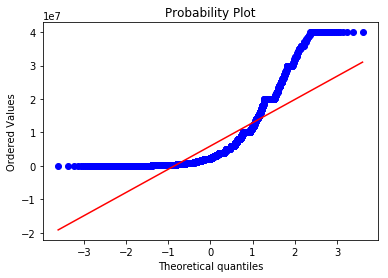

In [68]:
checkTargetInfo(train_df, target_name="target")

### apply logarithm transformation to tareget

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


14.4902392927 1.75075048295


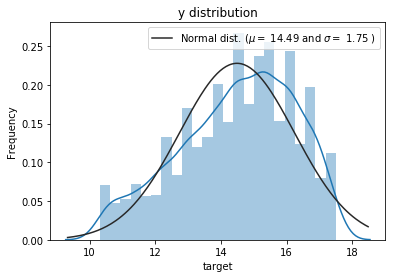

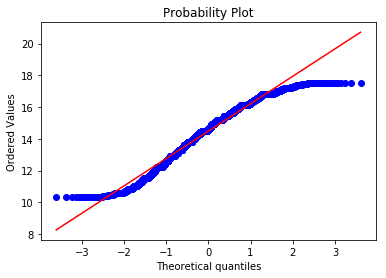

In [69]:
# apply logarithm transformation

train_df["target"] = np.log1p(train_df["target"])
sns.distplot(train_df["target"], fit=norm)

(mu, sigma) = norm.fit(train_df["target"])
print(mu, sigma)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(train_df["target"], plot=plt)
plt.show()


## check Correlation

## split To Id Target Features(train_df)

In [70]:
id_df, target_df, features_df = splitToIdTargetFeatures(train_df, id_name="ID", target_name="target")

id_df.head()

0    000d6aaf2
1    000fbd867
2    0027d6b71
3    0028cbf45
4    002a68644
Name: ID, dtype: object

In [71]:
target_df.head()

0    17.453097
1    13.304687
2    16.118096
3    14.508658
4    16.482739
Name: target, dtype: float64

In [72]:
features_df.head()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


## pairplot

- not good idea to make function
- better to use pairplot() directly. more useful.

----

# feature eng

In [73]:
ntrain = train_df.shape[0]
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)

all_id, all_target, all_data = splitToIdTargetFeatures(all_data, id_name="ID", target_name="target")


In [74]:
all_data.shape

(53802, 4991)

In [75]:
all_data.head()

,001476ffa,0019109c4,0022de2b3,0024cd760,002d634dc,00302fe51,003da5628,006e72749,007d71f12,007ee91d1,...,ffa45bf70,ffa6b80e2,ffa903344,ffb34b926,ffca57b7b,ffcec956f,ffd2f9409,ffd50f0bf,ffdc4bcf8,ffec49dae
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
all_data.tail()

,001476ffa,0019109c4,0022de2b3,0024cd760,002d634dc,00302fe51,003da5628,006e72749,007d71f12,007ee91d1,...,ffa45bf70,ffa6b80e2,ffa903344,ffb34b926,ffca57b7b,ffcec956f,ffd2f9409,ffd50f0bf,ffdc4bcf8,ffec49dae
53797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53801,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [77]:
all_id.head()

0    000d6aaf2
1    000fbd867
2    0027d6b71
3    0028cbf45
4    002a68644
Name: ID, dtype: object

In [78]:
all_id.tail()

53797    fff7b5923
53798    fff7c698f
53799    fff8dba89
53800    fffbe2f6f
53801          0.0
Name: ID, dtype: object

In [79]:
all_target.head()

0    17.453097
1    13.304687
2    16.118096
3    14.508658
4    16.482739
Name: target, dtype: float64

In [80]:
all_target.tail()

53797   NaN
53798   NaN
53799   NaN
53800   NaN
53801   NaN
Name: target, dtype: float64

## skew feature

In [81]:
skewness = checkSkewness(all_data)
skewness


# Skew in numerical features: 

                 Skew
55e30b08f  230.974841
455b51392  230.305953
28690ae0d  229.500405
470cea05f  228.830922
1614f0f84  228.321276
39896d3dd  228.283309
ed0860a34  228.029425
fe33df1c4  227.846197
f7f2e3896  227.770747
5c7eb01b4  227.529761
940c3b22f  227.510908
ba480f343  227.436025
39ebfbfd9  227.200467
3be4dad48  226.677297
6eebf3ca4  226.649999
2b85882ad  226.365177
3c7c7e24c  226.245410
6dcac05e7  226.123123
b3bfbc1fa  225.886324
5878b703c  225.658195
e9f57e5c6  225.652363
e325dec5e  225.601039
9685f5e16  225.469768
1b41a7ee2  225.438692
95bbebdd4  225.085799
907e76fa9  225.066646
8706aa459  224.786776
cf3841208  224.728656
e2c21c4bc  224.713659
07cb6041d  224.654121
...               ...
62e59a501   13.481640
9fd594eec   13.097759
bd6da0cca   12.633439
1db387535   12.518144
324921c7b   12.396595
02861e414   12.310006
f02ecb19c   12.288383
70feb1494   12.160715
20aa07010   12.082064
5c6487af1   11.971548
1702b5bf0   11.822818
58e056e12   11.785038

,Skew
55e30b08f,230.974841
455b51392,230.305953
28690ae0d,229.500405
470cea05f,228.830922
1614f0f84,228.321276
39896d3dd,228.283309
ed0860a34,228.029425
fe33df1c4,227.846197
f7f2e3896,227.770747
5c7eb01b4,227.529761


In [82]:
skewness.index[:10]

Index(['55e30b08f', '455b51392', '28690ae0d', '470cea05f', '1614f0f84',
       '39896d3dd', 'ed0860a34', 'fe33df1c4', 'f7f2e3896', '5c7eb01b4'],
      dtype='object')

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


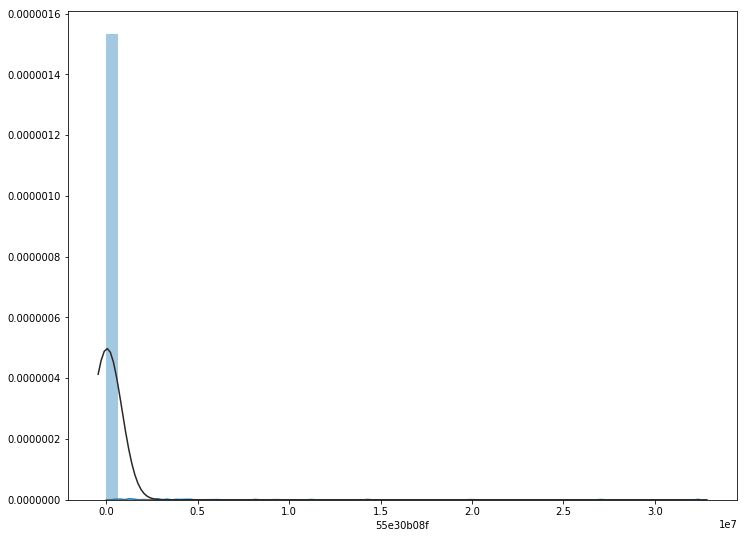

0           4421
3400000        2
580000         2
100000         1
20000000       1
27110000       1
1600000        1
920000         1
10000          1
4200000        1
2000000        1
1230000        1
11153176       1
1500000        1
32400000       1
3900000        1
320000         1
14320000       1
6000000        1
770000         1
180000         1
1448000        1
1220000        1
3972000        1
138000         1
2784000        1
2800000        1
588000         1
8124000        1
4600000        1
9320000        1
1300000        1
480000         1
1139414        1
316000         1
4420000        1
4444000        1
Name: 55e30b08f, dtype: int64


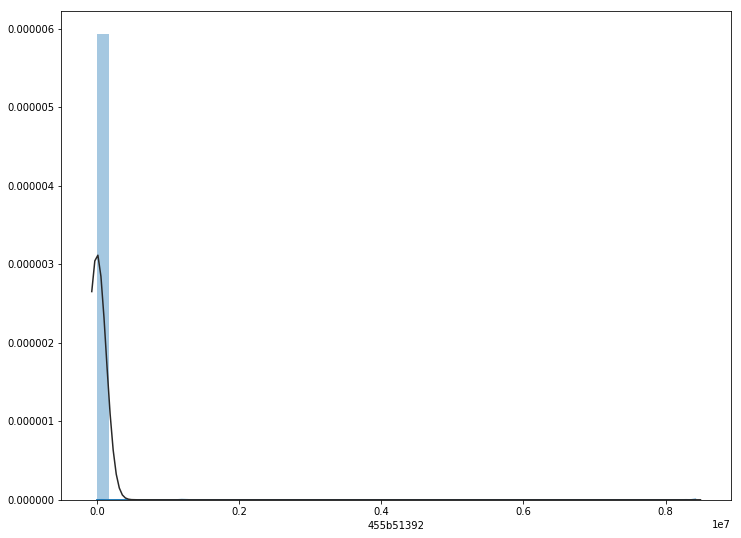

0          4455
1220000       1
8420000       1
60000         1
100000        1
Name: 455b51392, dtype: int64


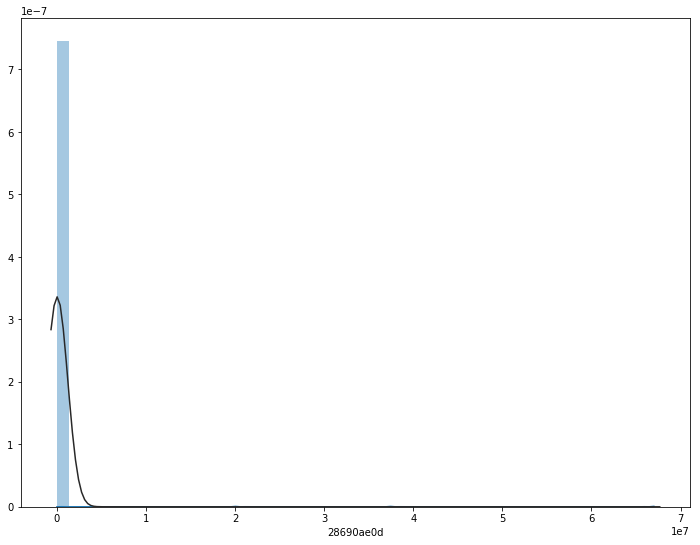

0           4452
8000           1
400000         1
6000           1
67000000       1
4000           1
37400000       1
20000000       1
Name: 28690ae0d, dtype: int64


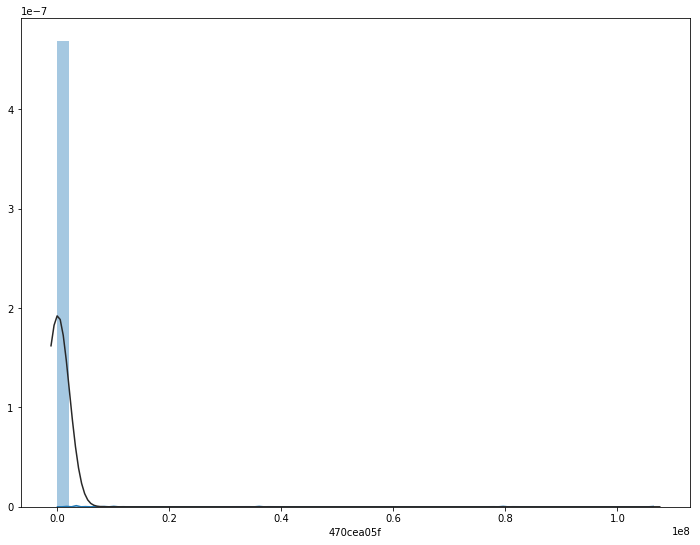

0            4441
3420000         3
400000          2
360000          1
79600000        1
106420000       1
10000000        1
300000          1
4800            1
8000000         1
36000000        1
1600000         1
600000          1
2000000         1
140000          1
328000          1
Name: 470cea05f, dtype: int64


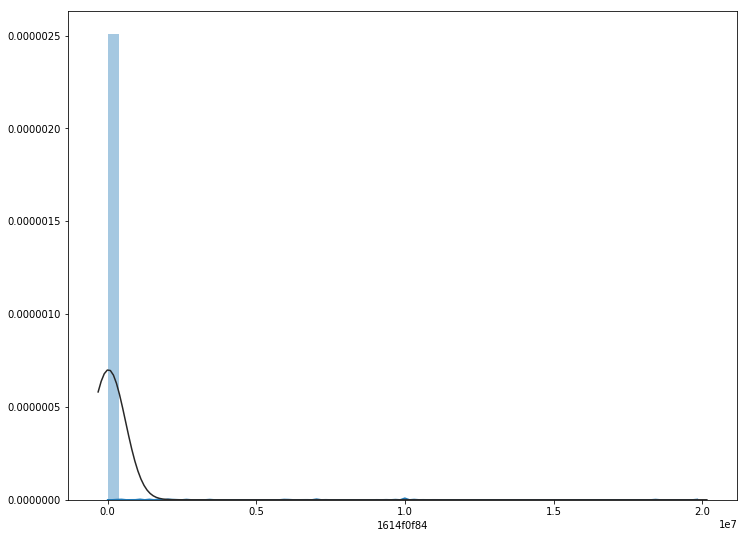

0           4428
10000000       4
6000000        2
534800         1
188620         1
2204000        1
1000000        1
18400000       1
1377360        1
2000000        1
1709342        1
370000         1
2672000        1
100000         1
256000         1
56000          1
380000         1
7000000        1
3412000        1
10400000       1
303402         1
70000          1
7009000        1
1070000        1
300000         1
19830000       1
30000          1
2092000        1
Name: 1614f0f84, dtype: int64


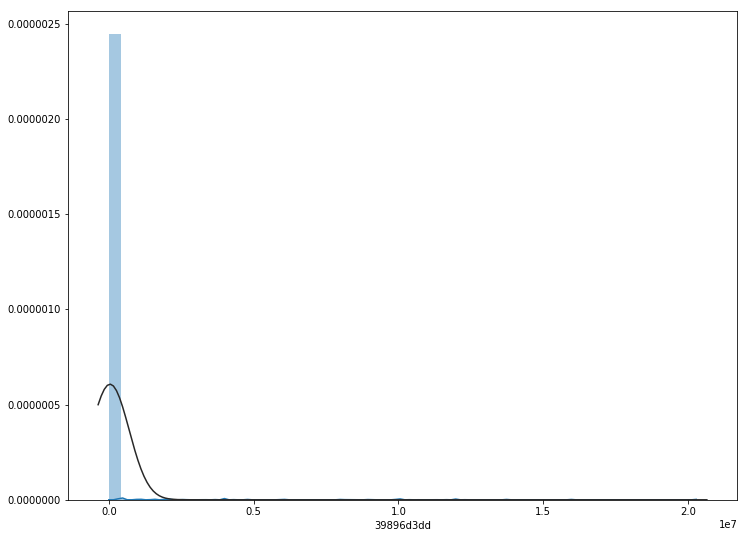

0.00           4382
200000.00        10
10000000.00       4
2000000.00        3
4000000.00        3
6000000.00        2
12000000.00       2
400000.00         2
1000000.00        2
320000.00         1
228000.00         1
460000.00         1
4800000.00        1
11438.00          1
20286000.00       1
178982.00         1
38000.00          1
30000.00          1
440000.00         1
22000.00          1
16000000.00       1
156000.00         1
20000.00          1
8200000.00        1
1600000.00        1
410000.00         1
600000.00         1
500000.00         1
78000.00          1
42000.00          1
84000.00          1
272000.00         1
466666.66         1
10000.00          1
1110000.00        1
266000.00         1
88000.00          1
178000.00         1
8000000.00        1
40000.00          1
182000.00         1
46000.00          1
92000.00          1
1500000.00        1
48000.00          1
98000.00          1
34000.00          1
9000000.00        1
157000.00         1
80000.00          1


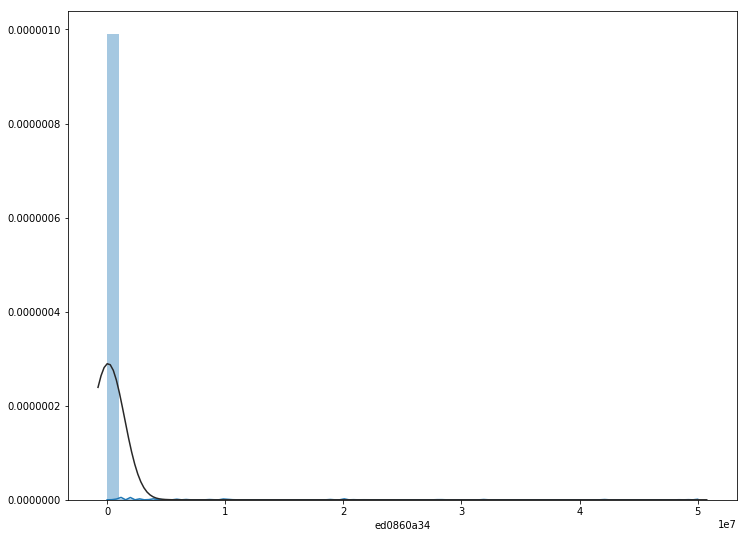

0.00           4379
200000.00         5
1000000.00        4
2000000.00        4
4000000.00        3
10000000.00       3
20000000.00       3
100000.00         2
540000.00         2
600000.00         2
360000.00         2
120000.00         2
1500000.00        2
2206000.00        1
230000.00         1
3333333.34        1
800000.00         1
300000.00         1
195000.00         1
5780000.00        1
252000.00         1
32000000.00       1
164000.00         1
1100000.00        1
1870000.00        1
640000.00         1
10400000.00       1
6819000.00        1
50000.00          1
8733333.34        1
42000000.00       1
4528000.00        1
1218000.00        1
86000.00          1
18866666.66       1
428666.66         1
9690000.00        1
1200000.00        1
40000.00          1
180000.00         1
2716000.00        1
982000.00         1
1800000.00        1
280000.00         1
302000.00         1
3792000.00        1
1038000.00        1
70000.00          1
355000.00         1
6000000.00        1


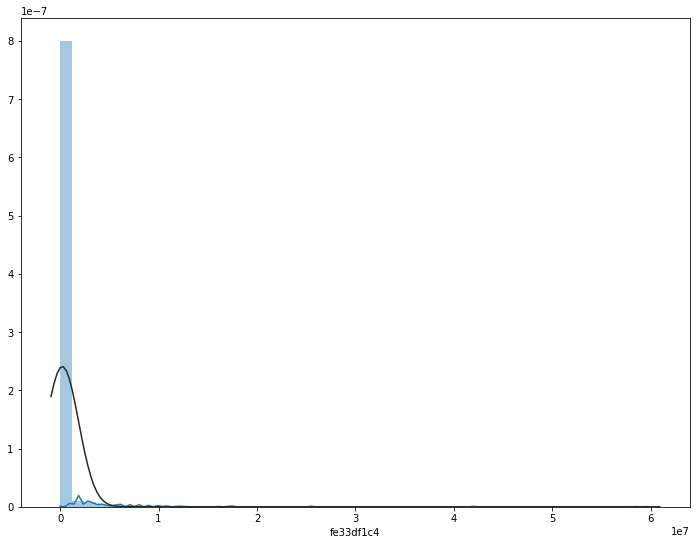

0.00           4131
2002166.66       18
200000.00        17
1600000.00       15
3000000.00       13
3862.00           9
6000000.00        8
700000.00         8
140000.00         6
4000000.00        6
500000.00         4
8000000.00        4
1000000.00        4
7000000.00        3
10000000.00       3
400000.00         3
250000.00         3
2266666.66        2
12000000.00       2
2600000.00        2
1800000.00        2
6800000.00        2
10000.00          2
2000000.00        2
20000.00          2
5000000.00        2
600000.00         2
172600.00         2
300000.00         2
100000.00         2
               ... 
5856.00           1
5717428.58        1
3492561.14        1
7372000.00        1
50000.00          1
30000.00          1
733980.00         1
17600000.00       1
3244.00           1
17200000.00       1
9400000.00        1
540000.00         1
4119200.00        1
3234000.00        1
17220000.00       1
620000.00         1
1005000.00        1
2840000.00        1
4116666.66        1


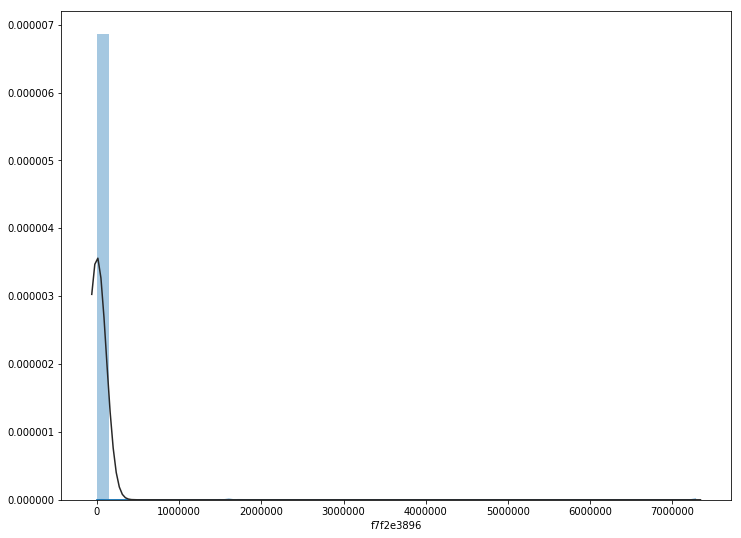

0          4457
7280000       1
1600000       1
Name: f7f2e3896, dtype: int64


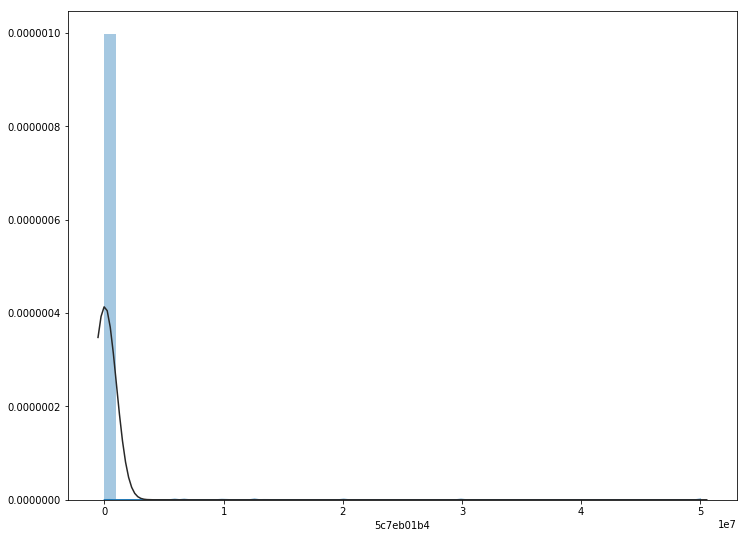

0           4452
10000000       1
50000000       1
6000000        1
20000000       1
30000000       1
12600000       1
6800000        1
Name: 5c7eb01b4, dtype: int64


In [83]:
for column in skewness.index[:10]:
    plt.subplots(figsize=(12,9))
    sns.distplot(train_df[column], fit=norm)
    plt.show()
    print(train_df[column].value_counts())

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


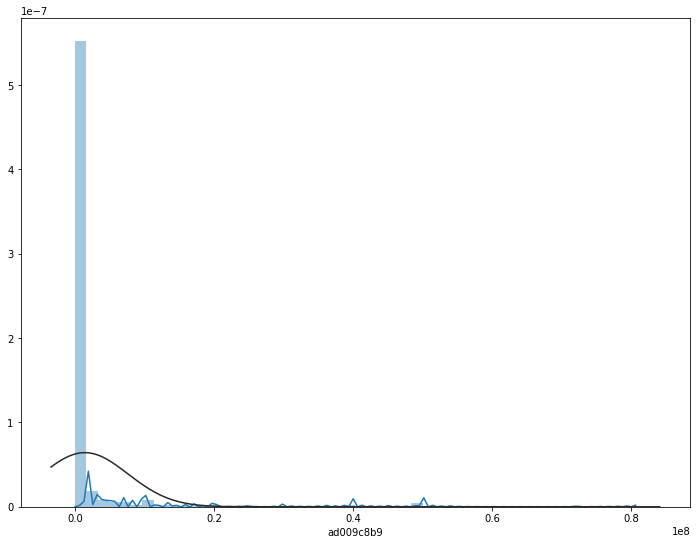

0.00           3617
10000000.00      33
50000000.00      30
200000.00        24
2000000.00       23
4000000.00       23
1775333.34       18
800000.00        18
20000000.00      17
40000000.00      17
400000.00        16
570000.00        16
7000000.00       16
9777000.00       16
2056000.00       14
500000.00        14
300000.00        14
444000.00        13
8000000.00       13
1000000.00       12
2800000.00       11
600000.00        11
6000000.00       10
5000000.00       10
100000.00        10
1200000.00        9
526000.00         9
1866666.66        8
180000.00         7
1330000.00        7
               ... 
2803333.34        1
25000000.00       1
1582000.00        1
220000.00         1
5738000.00        1
2836000.00        1
5150000.00        1
167000.00         1
420000.00         1
1734000.00        1
3458000.00        1
1300000.00        1
880000.00         1
12300000.00       1
848000.00         1
2966000.00        1
25300000.00       1
1614000.00        1
11470000.00       1


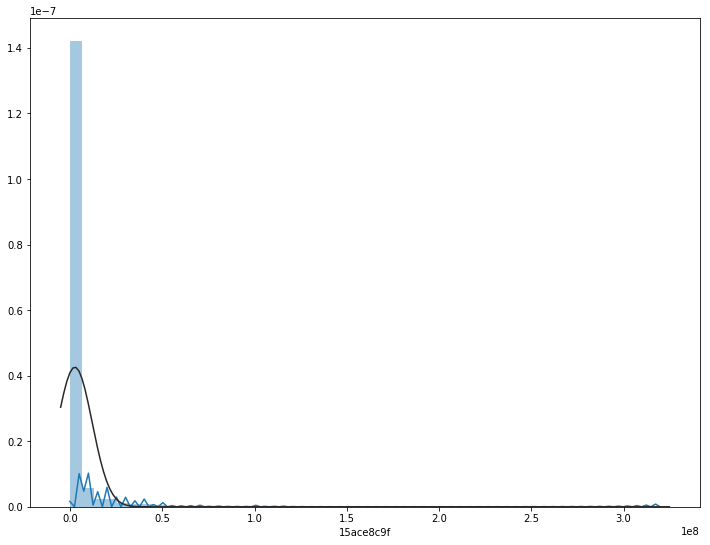

0.00           2974
2000000.00       54
10000000.00      44
4000000.00       34
1000000.00       31
200000.00        30
400000.00        28
20000000.00      27
600000.00        24
6000000.00       22
5000000.00       21
3000000.00       17
8000000.00       16
500000.00        16
30000000.00      15
100000.00        15
800000.00        14
700000.00        12
50000.00         11
40000000.00      11
1500000.00       11
1600000.00       10
1400000.00        9
40000.00          9
7000000.00        9
2500000.00        8
2000.00           8
1200000.00        8
10000.00          8
14000000.00       8
               ... 
7100000.00        1
1238000.00        1
3590000.00        1
3076666.66        1
1565500.00        1
210000.00         1
10195666.66       1
147090.90         1
33000000.00       1
83500.00          1
206666.66         1
37000000.00       1
1484000.00        1
1167333.34        1
206000.00         1
1012500.00        1
1838333.34        1
448666.66         1
3225333.34        1


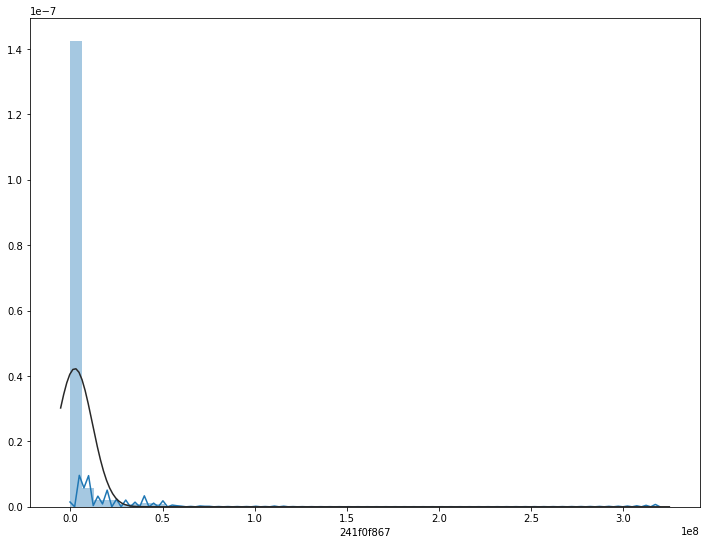

0.00           2998
2000000.00       54
10000000.00      43
20000000.00      26
200000.00        22
40000000.00      21
1000000.00       20
7000000.00       19
500000.00        19
8000000.00       18
600000.00        17
6000000.00       17
4000000.00       16
400000.00        16
1563411.76       15
800000.00        15
5000000.00       14
3000000.00       14
420000.00        14
4998800.00       13
1250000.00       13
50000000.00      12
375000.00        11
798000.00        11
58000.00         11
1600000.00       11
700000.00        11
338000.00        11
30000000.00      10
1200000.00       10
               ... 
3442000.00        1
15400000.00       1
4291000.00        1
19100000.00       1
5243333.34        1
12800000.00       1
2061333.34        1
605000.00         1
805333.34         1
3260000.00        1
15200000.00       1
7700000.00        1
4640000.00        1
23985000.00       1
128000.00         1
782500.00         1
3665000.00        1
979000.00         1
4870000.00        1


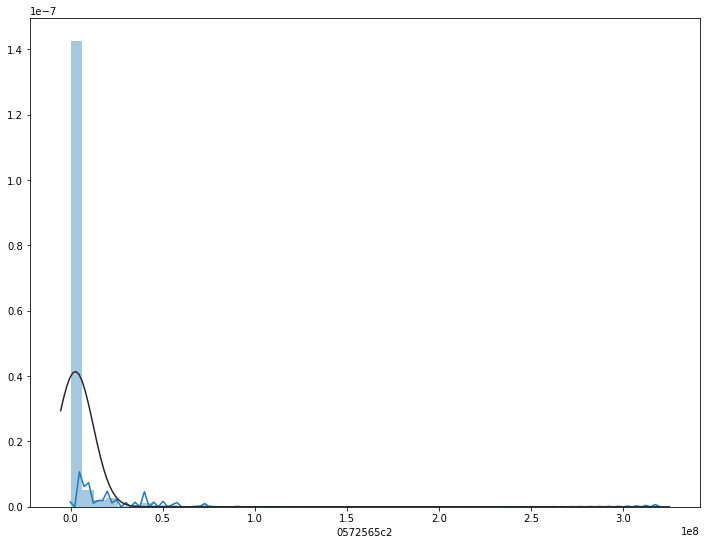

0.00           2912
2000000.00       44
10000000.00      34
200000.00        34
20000000.00      32
1563411.76       31
40000000.00      29
4000000.00       27
7000000.00       26
4998800.00       24
1250000.00       24
420000.00        23
798000.00        23
400000.00        23
500000.00        20
700000.00        19
600000.00        19
58000.00         18
526000.00        18
375000.00        18
3961600.00       17
57071428.58      17
23333333.34      16
1000000.00       16
338000.00        16
64800.00         15
1420000.00       14
8000000.00       14
1200000.00       14
1500000.00       14
               ... 
1420500.00        1
98000.00          1
490000.00         1
192000.00         1
4825000.00        1
726000.00         1
371000.00         1
1140000.00        1
5346500.00        1
8596000.00        1
2575000.00        1
19552000.00       1
206000.00         1
5216000.00        1
3225333.34        1
448666.66         1
1838333.34        1
4050000.00        1
2461428.58        1


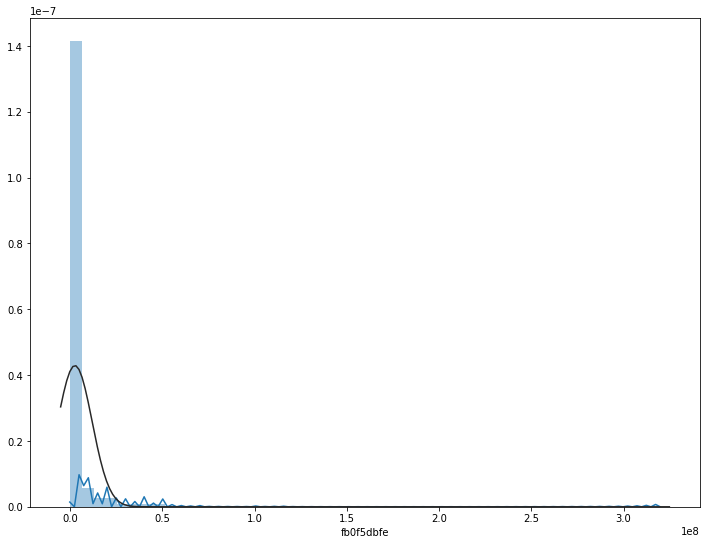

0.00           2964
2000000.00       48
10000000.00      44
20000000.00      35
4000000.00       34
1000000.00       32
400000.00        28
200000.00        28
6000000.00       24
600000.00        22
8000000.00       17
5000000.00       17
40000000.00      16
50000000.00      15
500000.00        15
800000.00        14
1200000.00       14
30000000.00      12
1500000.00       12
7000000.00       11
30000.00         11
3000000.00       10
700000.00         9
300000.00         9
40000.00          9
120000.00         8
1600000.00        7
1400000.00        7
1800000.00        7
3500000.00        7
               ... 
35050000.00       1
2056500.00        1
72200000.00       1
106000.00         1
25300000.00       1
147090.90         1
1020000.00        1
9666666.66        1
4752000.00        1
3785000.00        1
766000.00         1
7012000.00        1
1810800.00        1
54800000.00       1
1101157.90        1
110000.00         1
803333.34         1
13600000.00       1
5266666.66        1


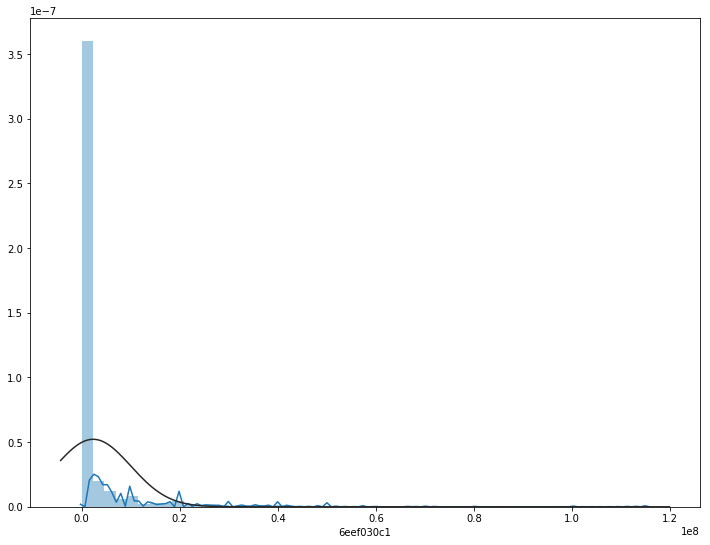

0.00           3004
10000000.00      50
2000000.00       44
20000000.00      35
4000000.00       34
6000000.00       31
200000.00        30
5000000.00       26
400000.00        22
1000000.00       21
600000.00        21
800000.00        18
8000000.00       17
7000000.00       14
30000000.00      13
700000.00        12
3000000.00       12
30000.00         11
1200000.00       11
500000.00        11
1500000.00       10
40000000.00      10
40000.00          9
50000.00          9
1800000.00        9
2000.00           9
50000000.00       8
10000.00          8
2500000.00        8
14000000.00       7
               ... 
5266666.66        1
605000.00         1
1209090.90        1
3442000.00        1
4640000.00        1
12432000.00       1
7700000.00        1
21100000.00       1
13500000.00       1
2703000.00        1
82666.66          1
1275333.34        1
3785000.00        1
11470000.00       1
4752000.00        1
805333.34         1
25300000.00       1
5161428.58        1
282333.34         1


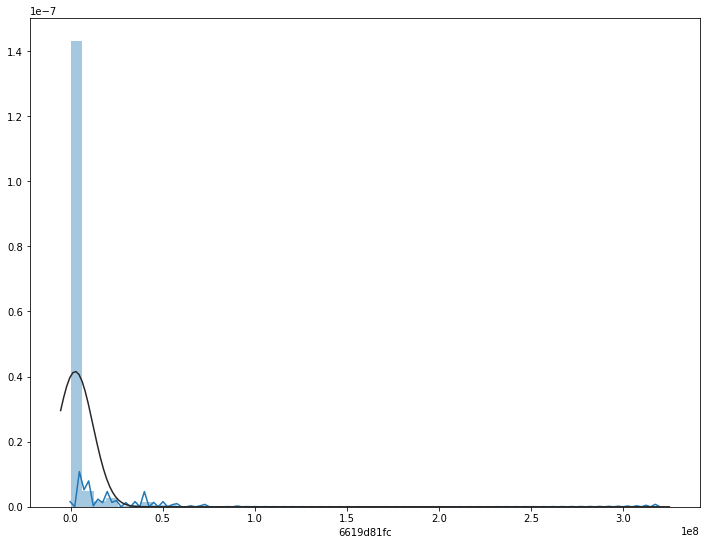

0.00           2926
2000000.00       62
10000000.00      40
200000.00        29
1563411.76       28
40000000.00      28
20000000.00      28
4000000.00       26
1000000.00       25
4998800.00       24
7000000.00       23
1250000.00       21
420000.00        21
798000.00        20
58000.00         19
6000000.00       19
700000.00        17
338000.00        17
375000.00        17
600000.00        16
400000.00        16
500000.00        16
526000.00        15
23333333.34      15
57071428.58      14
3961600.00       14
1420000.00       13
5000000.00       13
3000000.00       13
64800.00         13
               ... 
7333333.34        1
1760000.00        1
2116666.66        1
10160000.00       1
67500.00          1
106000.00         1
7200000.00        1
21000000.00       1
782500.00         1
5233692.30        1
1810800.00        1
54800000.00       1
220000.00         1
803333.34         1
1300000.00        1
20325000.00       1
3358333.34        1
9950000.00        1
14145000.00       1


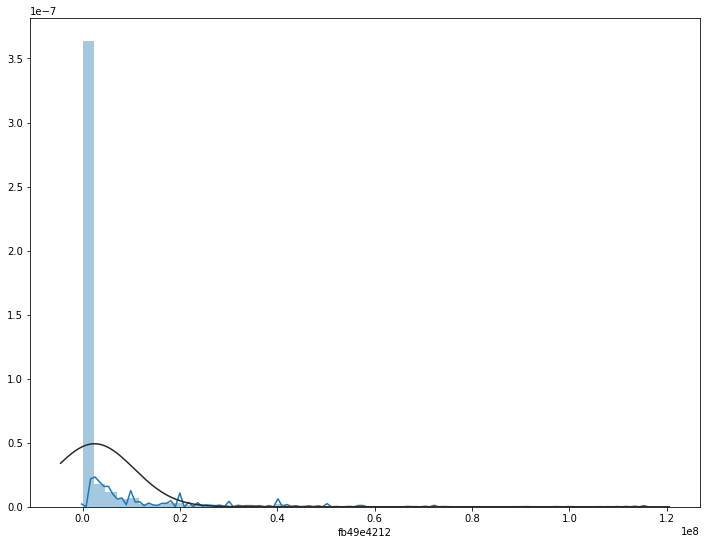

0.00           2977
2000000.00       53
10000000.00      39
4000000.00       30
200000.00        27
20000000.00      27
6000000.00       23
1000000.00       22
400000.00        21
5000000.00       19
700000.00        17
7000000.00       17
40000000.00      17
600000.00        17
1563411.76       16
800000.00        16
420000.00        15
338000.00        14
3000000.00       14
500000.00        14
4998800.00       14
1250000.00       13
58000.00         13
8000000.00       13
40000.00         12
798000.00        12
375000.00        12
30000000.00      11
2000.00          10
1200000.00       10
               ... 
7900000.00        1
922000.00         1
204666.66         1
1565500.00        1
33333333.34       1
21118400.00       1
2090000.00        1
1736000.00        1
315333.34         1
37000000.00       1
510000.00         1
570000.00         1
1760000.00        1
5346500.00        1
498000.00         1
8596000.00        1
2575000.00        1
3453333.34        1
16932000.00       1


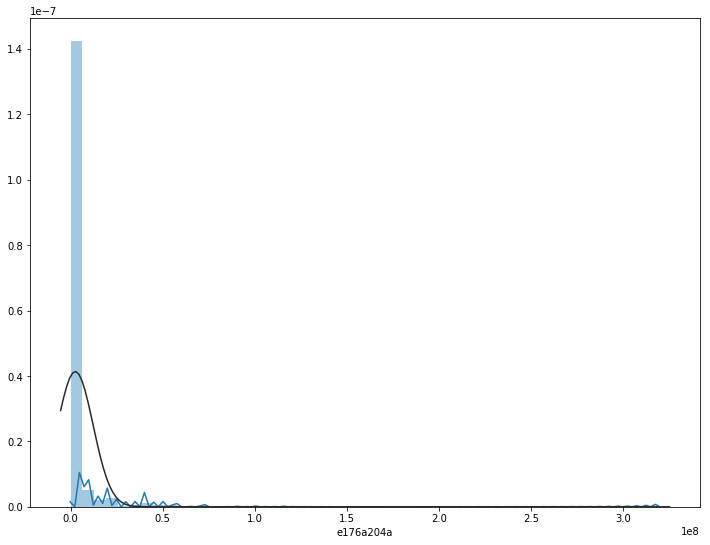

0.00           2924
2000000.00       55
10000000.00      42
20000000.00      34
4000000.00       33
200000.00        29
1563411.76       27
40000000.00      27
6000000.00       25
7000000.00       24
4998800.00       24
400000.00        22
1250000.00       21
420000.00        21
1000000.00       20
798000.00        20
700000.00        18
58000.00         18
338000.00        17
375000.00        17
500000.00        15
23333333.34      15
2000.00          15
57071428.58      14
3961600.00       14
526000.00        14
1200000.00       14
1420000.00       13
64800.00         13
600000.00        12
               ... 
1392666.66        1
7734285.72        1
37134000.00       1
10849666.66       1
908000.00         1
650000.00         1
7200000.00        1
1109714.28        1
1630000.00        1
128500.00         1
82666.66          1
3800000.00        1
7700000.00        1
290000.00         1
23985000.00       1
85500.00          1
46000.00          1
766000.00         1
1760000.00        1


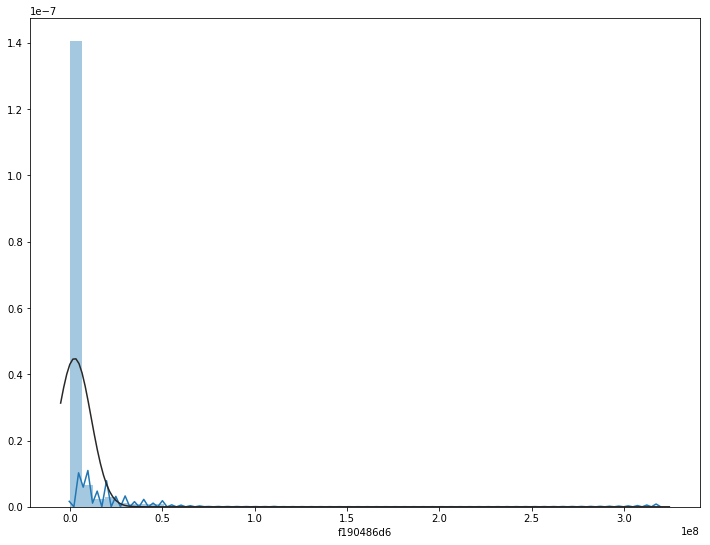

0.00           2915
2000000.00       62
10000000.00      57
20000000.00      43
4000000.00       38
1000000.00       28
200000.00        27
6000000.00       24
5000000.00       24
400000.00        23
600000.00        23
30000000.00      19
3000000.00       17
8000000.00       15
1200000.00       13
300000.00        13
1400000.00       13
800000.00        12
7000000.00       12
40000000.00      11
500000.00        11
50000000.00      11
700000.00        11
10000.00         11
20000.00         10
40000.00         10
1600000.00        8
100000.00         8
2000.00           7
450000.00         7
               ... 
766000.00         1
208666.66         1
11600000.00       1
128000.00         1
36000000.00       1
1209090.90        1
23985000.00       1
3192727.28        1
580000.00         1
13500000.00       1
32640000.00       1
5161428.58        1
8500000.00        1
282333.34         1
2066666.66        1
20325000.00       1
1260000.00        1
14300000.00       1
588000.00         1


In [84]:
for column in skewness.index[-10:]:
    plt.subplots(figsize=(12,9))
    sns.distplot(train_df[column], fit=norm)
    plt.show()
    print(train_df[column].value_counts())

## remove single value column in train_df 

In [85]:
single_val_columns = findSingleValueColmuns(train_df)

In [86]:
print("drop single value columns, ", len(single_val_columns), "columns were dropped")

drop single value columns,  256 columns were dropped


In [87]:
print("train_df.shape, test_df.shape")
print(train_df.shape, test_df.shape)
train_df.drop(single_val_columns, axis=1, inplace=True)
test_df.drop(single_val_columns, axis=1, inplace=True)
print(train_df.shape, test_df.shape)

train_df.shape, test_df.shape
(4459, 4993) (49343, 4992)
(4459, 4737) (49343, 4736)


## find boolean feature

In [ ]:
checkValueCounts(all_data)

## Box Cox Transformation of (highly) skewed features

almost all are boolean features.

need to exclude boolean for trans


----

# prepare train/test data

## with categorical feature
X_train_with_cat, X_test_with_cat, y_train_with_cat, y_test_with_cat

In [29]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#X_train_df_with_cat = train_df.drop(["y", "ID"], axis=1)
#y_train_df = train_df["y"]
#id_train_df = train_df["ID"]

id_train_df, y_train_df, X_train_df_with_cat = splitToIdTargetFeatures(train_df, id_name="ID", target_name="y")

In [31]:
print(id_train_df.head())
print(y_train_df.head())
print(X_train_df_with_cat.head())

0     0
1     6
2     7
3     9
4    13
Name: ID, dtype: int64
0    130.81
1     88.53
2     76.26
3     80.62
4     78.02
Name: y, dtype: float64
   X0 X1  X2 X3 X4 X5 X6 X8  X10  X11  ...   X375  X376  X377  X378  X379  \
0   k  v  at  a  d  u  j  o    0    0  ...      0     0     1     0     0   
1   k  t  av  e  d  y  l  o    0    0  ...      1     0     0     0     0   
2  az  w   n  c  d  x  j  x    0    0  ...      0     0     0     0     0   
3  az  t   n  f  d  x  l  e    0    0  ...      0     0     0     0     0   
4  az  v   n  f  d  h  d  n    0    0  ...      0     0     0     0     0   

   X380  X382  X383  X384  X385  
0     0     0     0     0     0  
1     0     0     0     0     0  
2     0     1     0     0     0  
3     0     0     0     0     0  
4     0     0     0     0     0  

[5 rows x 376 columns]


In [32]:
X_train_with_cat, X_test_with_cat, y_train_with_cat, y_test_with_cat = train_test_split(
    X_train_df_with_cat, y_train_df, 
    test_size=0.33, random_state=42)
print("train/test data shape", X_train_with_cat.shape, X_test_with_cat.shape)


train/test data shape (2820, 376) (1389, 376)


In [33]:
X_train_df_with_cat.head()

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,k,v,at,a,d,u,j,o,0,0,...,0,0,1,0,0,0,0,0,0,0
1,k,t,av,e,d,y,l,o,0,0,...,1,0,0,0,0,0,0,0,0,0
2,az,w,n,c,d,x,j,x,0,0,...,0,0,0,0,0,0,1,0,0,0
3,az,t,n,f,d,x,l,e,0,0,...,0,0,0,0,0,0,0,0,0,0
4,az,v,n,f,d,h,d,n,0,0,...,0,0,0,0,0,0,0,0,0,0


## get object type columns

In [34]:
obj_columns = X_train_df_with_cat.select_dtypes(include=['object'])
print(obj_columns.columns)

cat_dims = [X_train_df_with_cat.columns.get_loc(i) for i in obj_columns.columns] 
print(cat_dims)

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')
[0, 1, 2, 3, 4, 5, 6, 7]


## without categorical feature

X_train, X_test, y_train, y_test

In [35]:
id_train_df = train_df["ID"] # defining again. maybe in future, I will data set with categorical feature which I defined before. 
id_test_df = test_df["ID"]

In [36]:
# defining ntrain, all_data again. maybe in future, I will data set with categorical feature which I defined before.
ntrain = train_df.shape[0]
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
#all_data.drop(['y', "ID"], axis=1, inplace=True)
all_id, all_target, all_data  = splitToIdTargetFeatures(all_data, id_name="ID", target_name="y")

print("all_data.shape before: ", all_data.shape)
all_data = pd.get_dummies(all_data)
print("all_data.shape after get_dummies: ", all_data.shape)

train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

all_data.shape before:  (8418, 376)
all_data.shape after get_dummies:  (8418, 579)


In [37]:
print("train_df.shape: ", train_df.shape)
train_df.head()

train_df.shape:  (4209, 579)


,X10,X100,X101,X102,X103,X104,X105,X106,X107,X108,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df, y_train_df,
    test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)


train/test data shape (2820, 579) (1389, 579)


In [39]:
X_train.head()

,X10,X100,X101,X102,X103,X104,X105,X106,X107,X108,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
2218,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1688,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2242,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
582,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2132,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# base model

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from hyperopt import hp, tpe, Trials, fmin

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from mlxtend.regressor import StackingRegressor

## Defined find best parameter function by hyperopt module

### give model for hyperopt my funcs

In [41]:

def hyperopt_objective(model, X_train, y_train, scoring="r2", cv_size=5, n_jobs=3):
    """return objective function for hyperopt"""

    def objective(args):
#        print(model.steps[-1])
        model.steps[-1][1].set_params(**args)

        score = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv_size, n_jobs=n_jobs)
        return -score.mean()

    return objective





def searchHyperParam(model, par_space, X_train, y_train, scoring="r2", max_evals=100, cv_size=5, n_jobs=3):
    """search hyper parameter of a selected model"""

    objective = hyperopt_objective(model, X_train, y_train, scoring=scoring, cv_size=cv_size, n_jobs=n_jobs)
    
    #best_params = findBestParm(objective, par_space, X_train, y_train, scoring=scoring, max_evals=max_evals)

    trials = Trials()

    best = fmin(
        objective, 
        par_space, # 探索するパラメータのdictもしくはlist
        algo=tpe.suggest, # どのロジックを利用するか、基本的にはtpe.suggestでok
        max_evals=max_evals,
        trials=trials,
        verbose=1
    )
    print("best par: ", best)
    print("best trial: ", trials.best_trial["result"])
    #print("trials losses: ", trials.losses())
    
    return best


def evalModelByCV(model, X_train, y_train):
    """evaluate model by cross validation"""
    
    score = cross_val_score(model, X_train, y_train, scoring="r2", cv=5)

    print("model score: {:f} ({:f})\n" .format(
        score.mean(), score.std()))
    print("all scores: ", score)

    
def plot_my_learning_curves(X_train, y_train, X_test, y_test, model, scoring="r2", cv=5, n_jobs=3):
    """plot learning curves by mlxtend and my func my_plot_learning_curve()"""
    plot_learning_curves(X_train, y_train, X_test, y_test, 
                     model, scoring=scoring)
    plt.show()
    
    title = "Learning Curves"
    my_plot_learning_curve(model, title, 
                        X_train, y_train,
                        #ylim=(0.7, 1.01), 
                        cv=cv, scoring=scoring,
                        n_jobs=n_jobs)
    plt.show()

    
    

### give model_name for hyperopt my funcs

** NOT ACCTIVATED !!!**

## Def hyperopt param

In [42]:
cv_size = 5
max_evals = 10

## SVR

In [43]:
svr = make_pipeline(
    RobustScaler(),
    SVR()

)

kernel_list = ['rbf', 'poly', 'sigmoid']
par_space = {
    'C':hp.loguniform('C', -8, 2),
    'gamma':hp.loguniform('gamma', -8, 2),
    'epsilon':hp.loguniform('epsilon', -8, 2),
    'kernel':hp.choice('kernel', kernel_list)
}


In [45]:
best_params = {'C': 6.0125849233435975,
 'epsilon': 0.018596343856883617,
 'gamma': 0.019396603678872793,
 'kernel': 'rbf'}

model score: 0.560221 (0.038602)

all scores:  [0.50396199 0.57454623 0.55852882 0.62156701 0.54250185]


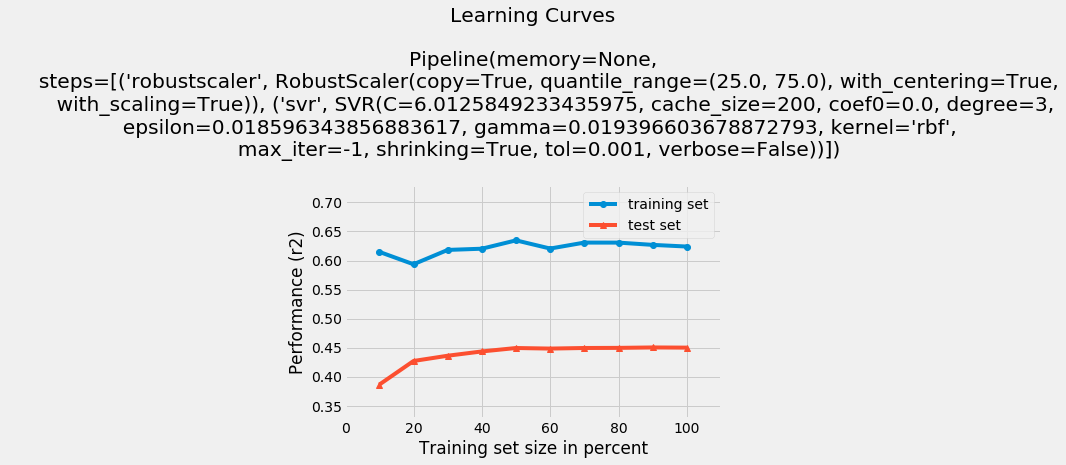

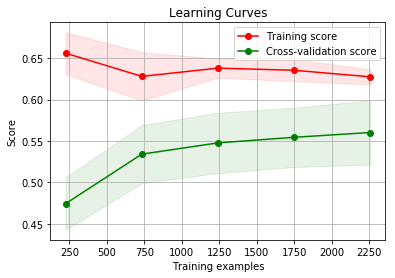

In [46]:
svr.steps[-1][1].set_params(**best_params)

evalModelByCV(svr, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, svr, scoring="r2", cv=5, n_jobs=3)

## lasso

In [47]:
lasso = make_pipeline(
    RobustScaler(),
    Lasso()

)

par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    
}

In [48]:
best_params = {'alpha': 0.03813148491610924}

/home/yuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


model score: 0.594549 (0.032242)

all scores:  [0.54734284 0.61750732 0.5864615  0.64116244 0.580271  ]


/home/yuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


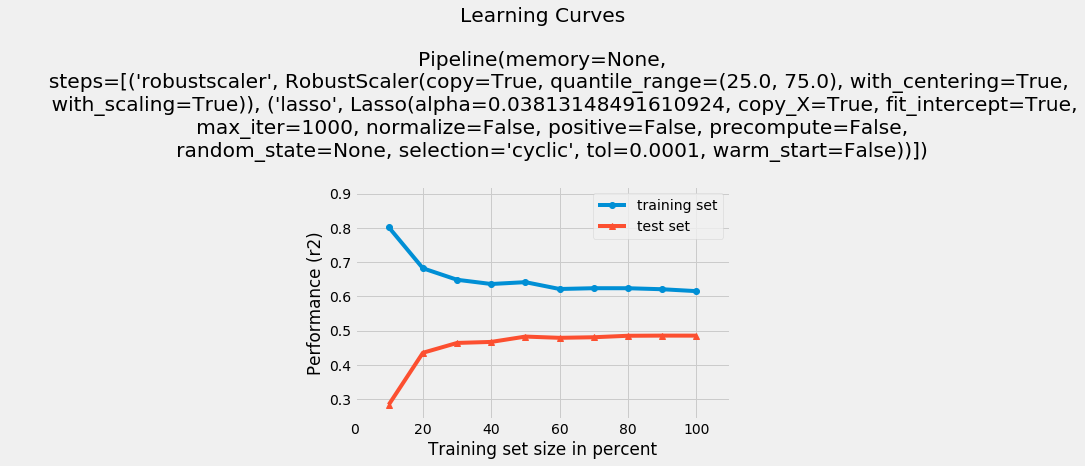

/home/yuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. 

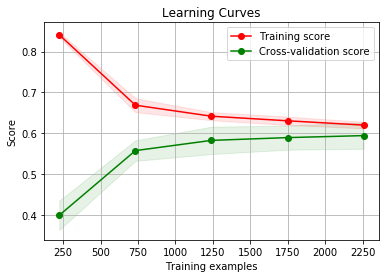

In [49]:

lasso.steps[-1][1].set_params(**best_params)

evalModelByCV(lasso, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, lasso, scoring="r2", cv=5, n_jobs=3)

## Elastic net

In [50]:
elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNet()

)
par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    'l1_ratio':hp.uniform('l1_ratio', 0, 1),
    
}

In [51]:
best_params = {'alpha': 0.03979354323226861, 'l1_ratio': 0.9027788528223015}

model score: 0.592658 (0.032608)

all scores:  [0.54579514 0.61518801 0.58498386 0.64061131 0.57671275]


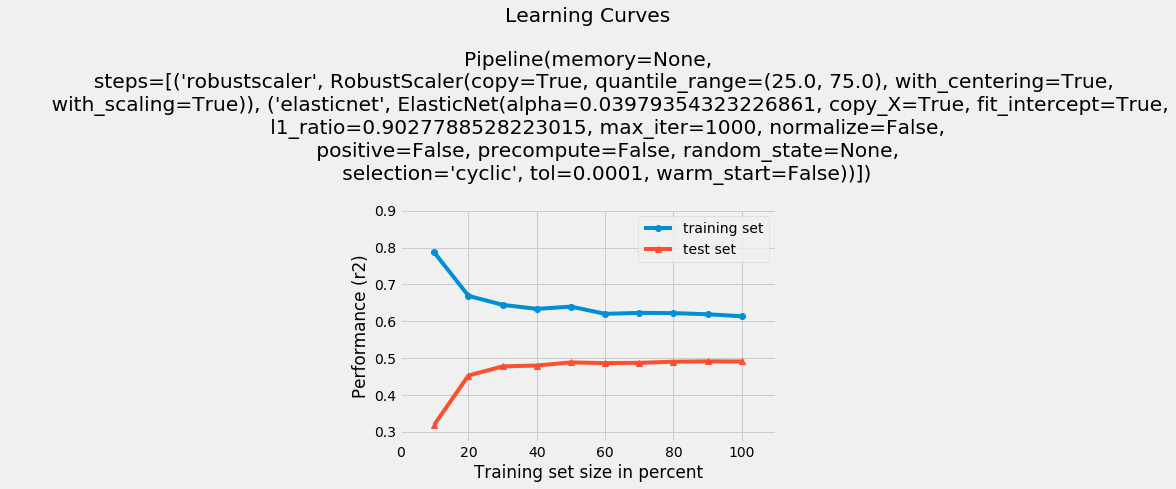

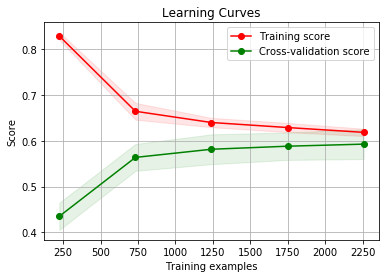

In [52]:

elasticnet.steps[-1][1].set_params(**best_params)

evalModelByCV(elasticnet, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, elasticnet, scoring="r2", cv=5, n_jobs=3)


## kernel ridge

In [53]:
krr = make_pipeline(
        #RobustScaler(),
        KernelRidge()
)

kernel_list = ['rbf', 'poly', 'sigmoid']
par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    'gamma':hp.loguniform('gamma', -8, 2),
    'kernel':hp.choice('kernel', kernel_list),
    'degree':hp.randint('degree', 5),
#    'coef0': # default value is enough
    
}

In [54]:
best_params = {'alpha': 0.06208805100456642,
 'degree': 2,
 'gamma': 0.000700959885815984,
 'kernel': 'rbf'}

model score: 0.583964 (0.032021)

all scores:  [0.53914429 0.60567647 0.57517786 0.63200974 0.56780952]


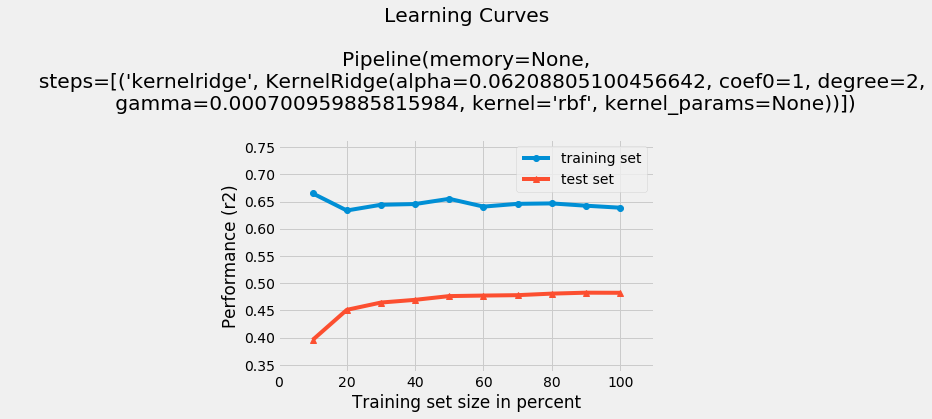

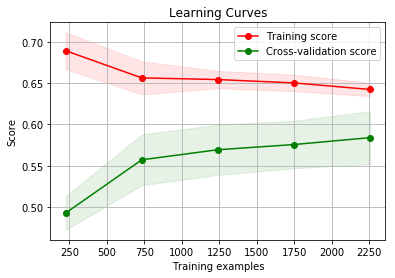

In [55]:
krr.steps[-1][1].set_params(**best_params)

evalModelByCV(krr, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, krr, scoring="r2", cv=5, n_jobs=3)


## k neighbers

In [56]:
knr = make_pipeline(
    #RobustScaler(),
    KNeighborsRegressor()
)

par_space = {
#    'n_neighbors':hp.choice('n_neighbors', [1,2,3,4,5,6,7,8,9,10]),
#    'n_neighbors':hp.quniform('n_neighbors', 1, 10, 1),
    'n_neighbors':hp.choice('n_neighbors', np.arange(1, 10, dtype=int))
#    'coef0': # default value is enough
    
}

In [57]:
best_params = {'n_neighbors': 8}

In [58]:
knr.steps[-1][1].set_params(**best_params)


evalModelByCV(knr, X_train, y_train)

plot_my_learning_curves(X_train, y_train, X_test, y_test, knr, scoring="r2", cv=5, n_jobs=3)

model score: 0.475911 (0.029694)

all scores:  [0.42226043 0.49608089 0.50629492 0.48734827 0.46757152]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/yuki/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-58-a5d9485c16ce>", line 6, in <module>
    plot_my_learning_curves(X_train, y_train, X_test, y_test, knr, scoring="r2", cv=5, n_jobs=3)
  File "<ipython-input-41-45ad3a49355a>", line 55, in plot_my_learning_curves
    model, scoring=scoring)
  File "/home/yuki/anaconda3/lib/python3.6/site-packages/mlxtend/plotting/learning_curves.py", line 107, in plot_learning_curves
    y_test_predict = clf.predict(X_test)
  File "/home/yuki/anaconda3/lib/python3.6/site-packages/sklearn/utils/metaestimators.py", line 115, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/home/yuki/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py", line 307, in predict
    return self.steps[-1][-1].predict(Xt)
  File "/home/yuki/anaconda3/lib/python3.6

KeyboardInterrupt: 

## Random forest

In [ ]:
ranfore = make_pipeline(
        #RobustScaler(),
        RandomForestRegressor()
)

par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'max_features':hp.choice('max_features', np.arange(1, 300, dtype=int)),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)),
    'min_samples_split':hp.choice('min_samples_split', np.arange(2, 10, dtype=int)),
    'min_samples_leaf':hp.choice('min_samples_leaf', np.arange(1, 9, dtype=int)),   
}

In [ ]:
best_params = {'max_depth': 5,
 'max_features': 226,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 56}

In [ ]:
ranfore.steps[-1][1].set_params(**best_params)

evalModelByCV(ranfore, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, ranfore, scoring="r2", cv=5, n_jobs=3)
# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(ranfore.named_steps["randomforestregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## gradient boosting

In [ ]:
gboostreg = make_pipeline(
        #RobustScaler(),
        GradientBoostingRegressor()
)

loss_list = ['ls', 'lad', 'huber', 'quantile']

par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_features':hp.choice('max_features', np.arange(1, 300, dtype=int)),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)),
    'min_samples_split':hp.choice('min_samples_split', np.arange(2, 30, dtype=int)),
    'min_samples_leaf':hp.choice('min_samples_leaf', np.arange(1, 29, dtype=int)),
    'loss':hp.choice('loss', loss_list),
    #'subsample':hp.uniform('learning_rate', 0.0, 1.0),
    
}


In [ ]:
best_params = {'learning_rate': 0.35189025799801155,
 'loss': 'huber',
 'max_depth': 3,
 'max_features': 119,
 'min_samples_leaf': 16,
 'min_samples_split': 19,
 'n_estimators': 48}

In [ ]:
gboostreg.steps[-1][1].set_params(**best_params)

evalModelByCV(gboostreg, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, gboostreg, scoring="r2", cv=5, n_jobs=3)
# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(gboostreg.named_steps["gradientboostingregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## XGBoost

In [80]:
xgbmodel = make_pipeline(
        #RobustScaler(),
        XGBRegressor()
)


par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)), 
    'gamma':hp.uniform('gamma', 0.0, 5.0),
    'min_child_weight':hp.uniform('min_child_weight', 0.0, 5.0),
    'subsample': hp.uniform('subsample', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.0, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -6, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -6, 2),
    'learning_rate': hp.uniform('learning_rate', 0.000000001, 1.0),
}

In [81]:
best_params = searchHyperParam(xgbmodel, par_space, X_train, y_train, scoring="r2", max_evals=max_evals, cv_size=cv_size, n_jobs=3)
best_params

best par:  {'colsample_bytree': 0.4708332878894328, 'gamma': 4.468853259609137, 'learning_rate': 0.05617427300476756, 'max_depth': 227, 'min_child_weight': 1.8959293704519609, 'n_estimators': 69, 'reg_alpha': 0.011073130482133953, 'reg_lambda': 0.00429738591644784, 'subsample': 0.034785099220768445}
best trial:  {'loss': -0.527460450939343, 'status': 'ok'}


{'colsample_bytree': 0.4708332878894328,
 'gamma': 4.468853259609137,
 'learning_rate': 0.05617427300476756,
 'max_depth': 227,
 'min_child_weight': 1.8959293704519609,
 'n_estimators': 69,
 'reg_alpha': 0.011073130482133953,
 'reg_lambda': 0.00429738591644784,
 'subsample': 0.034785099220768445}

In [82]:
best_params = {'colsample_bytree': 0.4708332878894328,
 'gamma': 4.468853259609137,
 'learning_rate': 0.05617427300476756,
 'max_depth': 227,
 'min_child_weight': 1.8959293704519609,
 'n_estimators': 69,
 'reg_alpha': 0.011073130482133953,
 'reg_lambda': 0.00429738591644784,
 'subsample': 0.034785099220768445}

model score: 0.524655 (0.034656)

all scores:  [0.46066925 0.56261035 0.53793854 0.54133879 0.52072045]


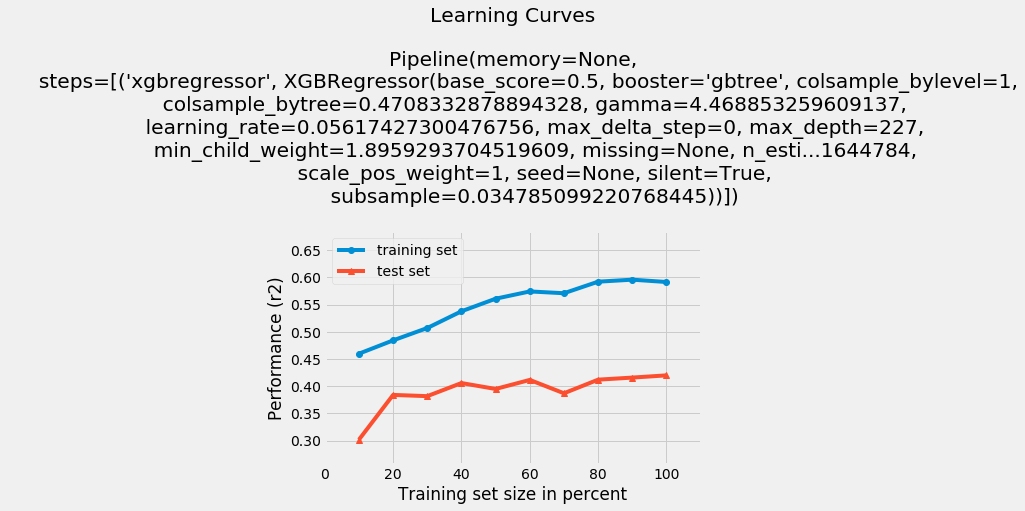

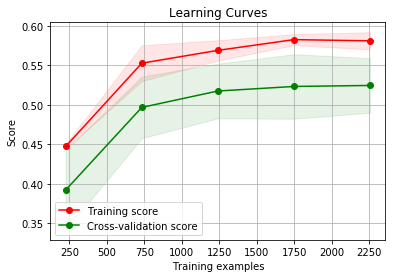

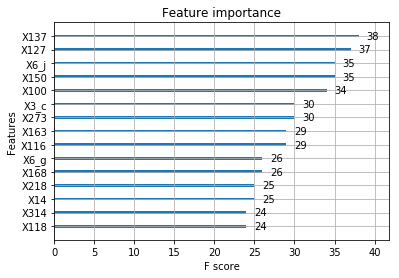

,variable,importance
40,X137,0.016777
29,X127,0.016336
551,X6_j,0.015453
54,X150,0.015453
1,X100,0.015011
186,X273,0.013245
500,X3_c,0.013245
18,X116,0.012804
68,X163,0.012804
548,X6_g,0.011479


In [83]:
xgbmodel.steps[-1][1].set_params(**best_params)

evalModelByCV(xgbmodel, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, xgbmodel, scoring="r2", cv=5, n_jobs=3)


xgb.plot_importance(xgbmodel.named_steps["xgbregressor"], max_num_features=15)
plt.show()

# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(xgbmodel.named_steps["xgbregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## LightGBM

In [84]:
lgbmodel = make_pipeline(
        #RobustScaler(),
        LGBMRegressor(**best_params)
)

par_space = {
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)), 
    'num_leaves':hp.choice('num_leaves', np.arange(2, 100, dtype=int)),
    'min_data_in_leaf':hp.choice('min_data_in_leaf', np.arange(1, 100, dtype=int)),
    
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'max_bin':hp.choice('max_bin', np.arange(2, 300, dtype=int)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.000000001, 1.0),
    'bagging_freq': hp.randint('bagging_freq', 10),
    'feature_fraction': hp.uniform('feature_fraction', 0.000000001, 1.0),
    'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', -6, 2),
}

In [85]:
best_params = searchHyperParam(lgbmodel, par_space, X_train, y_train, scoring="r2", max_evals=max_evals, cv_size=cv_size, n_jobs=3)
best_params

best par:  {'bagging_fraction': 0.6558599032364169, 'bagging_freq': 1, 'feature_fraction': 0.5858231364017451, 'learning_rate': 0.06116145520022197, 'max_bin': 87, 'max_depth': 131, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 0.4388796240028399, 'n_estimators': 64, 'num_leaves': 91}
best trial:  {'loss': -0.5687309624677311, 'status': 'ok'}


{'bagging_fraction': 0.6558599032364169,
 'bagging_freq': 1,
 'feature_fraction': 0.5858231364017451,
 'learning_rate': 0.06116145520022197,
 'max_bin': 87,
 'max_depth': 131,
 'min_data_in_leaf': 5,
 'min_sum_hessian_in_leaf': 0.4388796240028399,
 'n_estimators': 64,
 'num_leaves': 91}

In [87]:
# used 100 max_evalus score

best_params = {'bagging_fraction': 0.6488366999217055,
 'bagging_freq': 4,
 'feature_fraction': 0.8769912726752449,
 'learning_rate': 0.2322285924856258,
 'max_bin': 259,
 'max_depth': 46,
 'min_data_in_leaf': 34,
 'min_sum_hessian_in_leaf': 0.011853166137307664,
 'n_estimators': 54,
 'num_leaves': 3}

model score: 0.592850 (0.033613)

all scores:  [0.54754175 0.61707558 0.58038147 0.64347283 0.5757783 ]


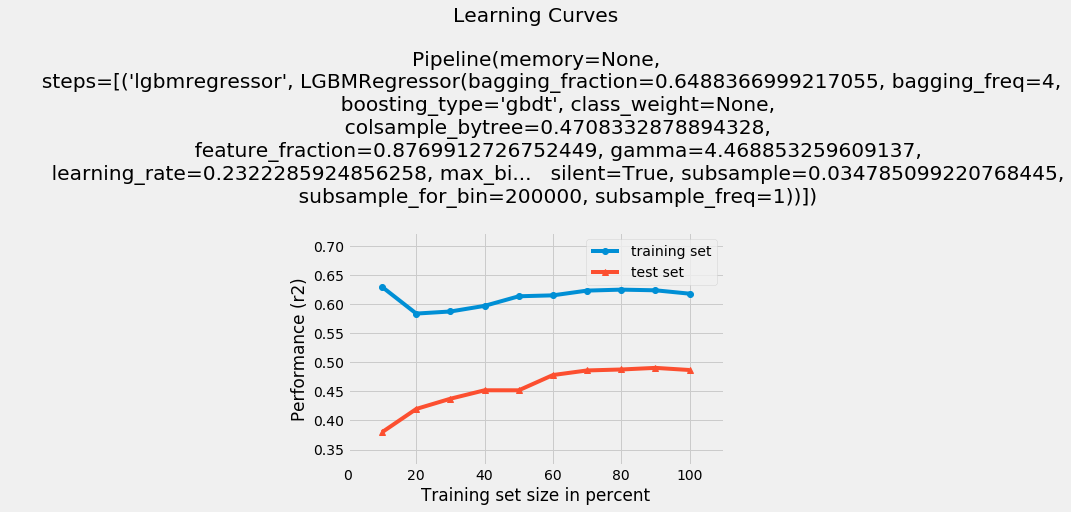

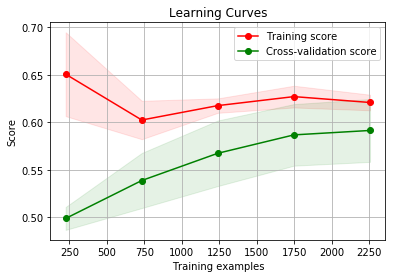

,variable,importance
39,X136,7
231,X315,7
29,X127,6
173,X261,4
538,X5_w,3
23,X120,3
391,X0_ay,3
230,X314,3
20,X118,3
55,X151,3


In [88]:
lgbmodel.steps[-1][1].set_params(**best_params)


evalModelByCV(lgbmodel, X_train, y_train)


plot_my_learning_curves(X_train, y_train, X_test, y_test, lgbmodel, scoring="r2", cv=5, n_jobs=3)

# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(lgbmodel.named_steps["lgbmregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)


### tried categorical_feature, but object type is not supported yet.
https://github.com/Microsoft/LightGBM/issues/1020

## catboost

In [ ]:
from catboost import CatBoostRegressor

print(list(obj_columns.columns.values))
print(cat_dims)

In [ ]:
X_train_with_cat.head()

In [ ]:
catReg = CatBoostRegressor(learning_rate=1,
                          depth=6,
                          loss_function='RMSE')

fit_model = catReg.fit(X_train_with_cat, y_train_with_cat, cat_features=cat_dims)


## TPOT

## todo

how to use R2 for scoring for catboost

https://tech.yandex.com/catboost/doc/dg/concepts/loss-functions-docpage/


# Stacking

/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


model score: 0.589658 (0.034918)

all scores:  [0.536513   0.60509833 0.58309899 0.64349815 0.58007963]


/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


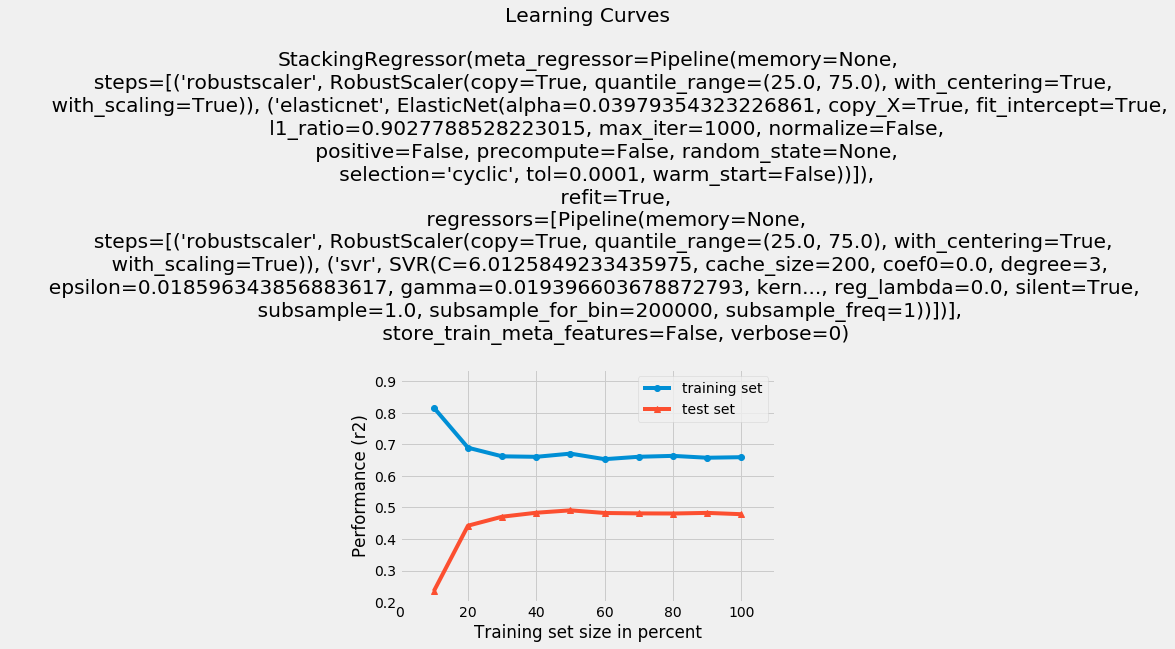

/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

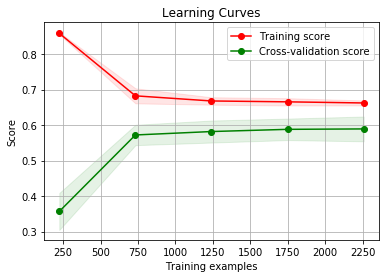

In [90]:
# svr, lasso, elasticnet, krr, knr, ranfore, gboostreg, xgbmodel

stregr = StackingRegressor(regressors=[
    svr,
    lasso, 
    #elasticnet, 
    #krr, 
    #knr, 
    ranfore, 
    gboostreg, 
    xgbmodel,
    lgbmodel,
],
                           meta_regressor=elasticnet)


evalModelByCV(stregr, X_train, y_train)


plot_my_learning_curves(X_train, y_train, X_test, y_test, stregr, scoring="r2", cv=5, n_jobs=3)



In [ ]:
stregr.

In [74]:
# https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.regressor/
stregr.coef_

AttributeError: 'Pipeline' object has no attribute 'coef_'

In [91]:
# Training the stacking classifier with all train data

stregr.fit(train_df, y_train_df)

StackingRegressor(meta_regressor=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.03979354323226861, copy_X=True, fit_intercept=True,
      l1_ratio=0.9027788528223015, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False))]),
         refit=True,
         regressors=[Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svr', SVR(C=6.0125849233435975, cache_size=200, coef0=0.0, degree=3,
  epsilon=0.018596343856883617, gamma=0.019396603678872793, kern..., reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=1))])],
         store_train_meta_features=False, verbose=0)

# Make submission file
https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/submissions?sortBy=date&group=all&page=1

In [92]:
sub = pd.DataFrame()
sub['ID'] = id_test_df
sub['y'] = stregr.predict(test_df)
sub.to_csv('../output/submission.csv', index=False)
